In [1]:
import pandas as pd
import numpy as np
import time
pd.set_option('display.max_columns', None)
# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# nlp libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# nlp libraries
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder
from nltk.probability import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

In [2]:
smartcat= pd.read_csv('G2_Reviews_Smarcat.csv')
lokalise= pd.read_csv('G2_Reviews_Lokalise.csv')
crowdin= pd.read_csv('G2_Reviews_Crowdin.csv')
transifex= pd.read_csv('G2_Reviews_Transifex.csv')
plp= pd.read_csv('G2_reviews_Phrase Localization Platform.csv')
murf_AI= pd.read_csv('G2_Reviews_Murf.ai.csv')

In [3]:
df = pd.concat([smartcat, lokalise, crowdin, transifex, plp, murf_AI])

In [4]:
df.head()

,username,date,url,rating,product_name,Pros,Cons
0,No username found,2023-09-19,https://www.g2.com/products/smartcat/reviews/s...,2.0,Smartcat,Quick to get started but again that might be a...,The console is not user friendly and the platf...
1,Alexis K.,2024-04-25,https://www.g2.com/products/smartcat/reviews/s...,5.0,Smartcat,1. Quality: 99% of phrases correctly translate...,Nothing. The quality of the service is excelle...
2,Alina C.,2024-04-23,https://www.g2.com/products/smartcat/reviews/s...,5.0,Smartcat,It's perfect for my needs and the volume of tr...,Management changed the focus of this software ...
3,Nebought K.,2024-05-17,https://www.g2.com/products/smartcat/reviews/s...,5.0,Smartcat,Splitting documents into segments makes it eas...,If there is little change you have to go throu...
4,Alexander M.,2023-10-15,https://www.g2.com/products/smartcat/reviews/s...,5.0,Smartcat,Intuitive UI/UX design. Amazing customer suppo...,The price could be a bit steep for startups.Wh...


In [5]:
print(f"There are {df['product_name'].nunique()} companies and {df.shape[0]} total reviews in our data.")

There are 6 companies and 2892 total reviews in our data.


In [6]:
df.groupby('product_name')['product_name'].count().rename('Number of Reviews').to_frame().reset_index()

,product_name,Number of Reviews
0,Crowdin,437
1,Lokalise,616
2,Murf.ai,1000
3,Phrase Localization Platform,100
4,Smartcat,117
5,Transifex,622


In [7]:
df.groupby('product_name')['rating'].mean().rename('Avg Rating').round(2).to_frame().reset_index()

,product_name,Avg Rating
0,Crowdin,4.51
1,Lokalise,4.73
2,Murf.ai,4.73
3,Phrase Localization Platform,4.53
4,Smartcat,4.53
5,Transifex,4.25


## Missing Values

In [8]:
df.isna().sum()

username        0
date            0
url             0
rating          0
product_name    0
Pros            7
Cons            7
dtype: int64

In [9]:
df[df['Pros'].isna()]['url'].to_list()

['https://www.g2.com/products/lokalise/reviews/lokalise-review-4855366',
 'https://www.g2.com/products/lokalise/reviews/lokalise-review-4974355',
 'https://www.g2.com/products/lokalise/reviews/lokalise-review-2774792',
 'https://www.g2.com/products/crowdin/reviews/crowdin-review-6953789',
 'https://www.g2.com/products/crowdin/reviews/crowdin-review-6529691',
 'https://www.g2.com/products/crowdin/reviews/crowdin-review-7231735',
 'https://www.g2.com/products/phrase-localization-platform/reviews/phrase-localization-platform-review-9366013']

In [10]:
# the missing values had a video reviews, so I dropped them to move further with my text analysis
df.dropna(subset=['Pros', 'Cons'], inplace=True)

## Text Processing

### Pros

In [11]:
# initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

# function for text preprocessing
def preprocess_text_nltk(text):
    # tokenize the text
    tokens = word_tokenize(text)
    # convert to lowercase
    tokens = [word.lower() for word in tokens]
    # remove punctuation and stop words, and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    # remove "translate" as it will skew the topic modeling and doesn't bring valuable  information
    tokens = [word for word in tokens if word not in ['translate', 'translation', 'translations', 'translators', 'translator']]
    return ' '.join(tokens)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# function for text preprocessing
def preprocess_text_spacy(text):
    # tokenize the text
    doc = nlp(text)
    
    # lemmatize the tokens and convert to lowercase
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_space]
    
    # remove stop words
    tokens = [token for token in tokens if token not in STOP_WORDS]
    # remove the word "translate"
    tokens = [token for token in tokens if token not in ['translate', 'translation', 'translations', 'translators', 'translator']]
    
    return ' '.join(tokens)

start_time = time.time()

df['processed_Pros_NLTK'] = df['Pros'].apply(preprocess_text_nltk)
df['processed_Pros_spaCy'] = df['Pros'].apply(preprocess_text_spacy)

end_time = time.time()
duration = (end_time - start_time)/ 60
print(f"Execution time: {duration:.2f} minutes")

Execution time: 0.26 minutes


In [12]:
df[['Pros', 'processed_Pros_NLTK']].head()

,Pros,processed_Pros_NLTK
0,Quick to get started but again that might be a...,quick get started might bane boon
1,1. Quality: 99% of phrases correctly translate...,1 quality 99 phrase correctly translated minim...
2,It's perfect for my needs and the volume of tr...,perfect need volume
3,Splitting documents into segments makes it eas...,splitting document segment make easy deal proj...
4,Intuitive UI/UX design. Amazing customer suppo...,intuitive design amazing customer support limi...


In [13]:
df[['Pros', 'processed_Pros_spaCy']].head()

,Pros,processed_Pros_spaCy
0,Quick to get started but again that might be a...,quick start bane boon
1,1. Quality: 99% of phrases correctly translate...,1 quality 99 phrase correctly minimum post pro...
2,It's perfect for my needs and the volume of tr...,perfect need volume
3,Splitting documents into segments makes it eas...,splitting document segment easy deal project r...
4,Intuitive UI/UX design. Amazing customer suppo...,intuitive ui ux design amazing customer suppor...


### Cons

In [14]:
# initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

# function for text preprocessing
def preprocess_text_nltk(text):
    # tokenize the text
    tokens = word_tokenize(text)
    # convert to lowercase
    tokens = [word.lower() for word in tokens]
    # remove punctuation and stop words, and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    tokens = [word for word in tokens if word not in ['translate', 'translation', 'translations', 'translators', 'translator']]
    return ' '.join(tokens)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# function for text preprocessing
def preprocess_text_spacy(text):
    # tokenize the text
    doc = nlp(text)
    
    # lemmatize the tokens and convert to lowercase
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_space]
    
    # remove stop words
    tokens = [token for token in tokens if token not in STOP_WORDS]
    tokens = [token for token in tokens if token not in ['translate', 'translation', 'translations', 'translators', 'translator']]
    return ' '.join(tokens)

start_time = time.time()

df['processed_Cons_NLTK'] = df['Cons'].apply(preprocess_text_nltk)
df['processed_Cons_spaCy'] = df['Cons'].apply(preprocess_text_spacy)

end_time = time.time()
duration = (end_time - start_time)/ 60
print(f"Execution time: {duration:.2f} minutes")

Execution time: 0.31 minutes


In [15]:
df[['Cons', 'processed_Cons_spaCy']].head()

,Cons,processed_Cons_spaCy
0,The console is not user friendly and the platf...,console user friendly platform non transparent...
1,Nothing. The quality of the service is excelle...,quality service excellent problem smartcat sol...
2,Management changed the focus of this software ...,management change focus software business comp...
3,If there is little change you have to go throu...,little change segment suggest add replace func...
4,The price could be a bit steep for startups.Wh...,price bit steep startup problem smartcat solve...


In [16]:
df[['Cons', 'processed_Cons_NLTK']].head()

,Cons,processed_Cons_NLTK
0,The console is not user friendly and the platf...,console user friendly platform non transparent...
1,Nothing. The quality of the service is excelle...,nothing quality service problem smartcat solvi...
2,Management changed the focus of this software ...,management changed focus software business pro...
3,If there is little change you have to go throu...,little change go segment suggest add replace f...
4,The price could be a bit steep for startups.Wh...,price could bit steep problem smartcat solving...


In [17]:
smartcat = df[df['product_name']=='Smartcat']
lokalise = df[df['product_name']=='Lokalise']
crowdin = df[df['product_name']=='Crowdin']
transifex = df[df['product_name']=='Transifex']
plp = df[df['product_name']=='Phrase Localization Platform']
murf_AI = df[df['product_name']=='Murf.ai']

## Sentiment Analysis with nltk

In [18]:
# pros
sa_smartcat_df_pros = smartcat.dropna(subset=['processed_Pros_NLTK'])
sa_smartcat_df_pros = sa_smartcat_df_pros.reset_index(drop=True)
sa_lokalise_df_pros = lokalise.dropna(subset=['processed_Pros_NLTK'])
sa_lokalise_df_pros = sa_lokalise_df_pros.reset_index(drop=True)
sa_crowdin_df_pros = crowdin.dropna(subset=['processed_Pros_NLTK'])
sa_crowdin_df_pros = sa_crowdin_df_pros.reset_index(drop=True)
sa_transifex_df_pros = transifex.dropna(subset=['processed_Pros_NLTK'])
sa_transifex_df_pros = sa_transifex_df_pros.reset_index(drop=True)
sa_plp_df_pros = plp.dropna(subset=['processed_Pros_NLTK'])
sa_plp_df_pros = sa_plp_df_pros.reset_index(drop=True)
sa_murf_AI_df_pros = murf_AI.dropna(subset=['processed_Pros_NLTK'])
sa_murf_AI_df_pros = sa_murf_AI_df_pros.reset_index(drop=True)

# cons
sa_smartcat_df_cons = smartcat.dropna(subset=['processed_Cons_NLTK'])
sa_smartcat_df_cons = sa_smartcat_df_cons.reset_index(drop=True)
sa_lokalise_df_cons = lokalise.dropna(subset=['processed_Cons_NLTK'])
sa_lokalise_df_cons = sa_lokalise_df_cons.reset_index(drop=True)
sa_crowdin_df_cons = crowdin.dropna(subset=['processed_Cons_NLTK'])
sa_crowdin_df_cons = sa_crowdin_df_cons.reset_index(drop=True)
sa_transifex_df_cons = transifex.dropna(subset=['processed_Cons_NLTK'])
sa_transifex_df_cons = sa_transifex_df_cons.reset_index(drop=True)
sa_plp_df_cons = plp.dropna(subset=['processed_Cons_NLTK'])
sa_plp_df_cons = sa_plp_df_cons.reset_index(drop=True)
sa_murf_AI_df_cons = murf_AI.dropna(subset=['processed_Cons_NLTK'])
sa_murf_AI_df_cons = sa_murf_AI_df_cons.reset_index(drop=True)

### 1. Create Bigrams

In [19]:
#pros
sa_smartcat_df_pros['tokens_pros'] = sa_smartcat_df_pros['processed_Pros_NLTK'].apply(lambda x: x.split())
sa_lokalise_df_pros['tokens_pros'] = sa_lokalise_df_pros['processed_Pros_NLTK'].apply(lambda x: x.split())
sa_crowdin_df_pros['tokens_pros'] = sa_crowdin_df_pros['processed_Pros_NLTK'].apply(lambda x: x.split())
sa_transifex_df_pros['tokens_pros'] = sa_transifex_df_pros['processed_Pros_NLTK'].apply(lambda x: x.split())
sa_plp_df_pros['tokens_pros'] = sa_plp_df_pros['processed_Pros_NLTK'].apply(lambda x: x.split())
sa_murf_AI_df_pros['tokens_pros'] = sa_murf_AI_df_pros['processed_Pros_NLTK'].apply(lambda x: x.split())
#cons
sa_smartcat_df_cons['tokens_cons'] = sa_smartcat_df_cons['processed_Cons_NLTK'].apply(lambda x: x.split())
sa_lokalise_df_cons['tokens_cons'] = sa_lokalise_df_cons['processed_Cons_NLTK'].apply(lambda x: x.split())
sa_crowdin_df_cons['tokens_cons'] = sa_crowdin_df_cons['processed_Cons_NLTK'].apply(lambda x: x.split())
sa_transifex_df_cons['tokens_cons'] = sa_transifex_df_cons['processed_Cons_NLTK'].apply(lambda x: x.split())
sa_plp_df_cons['tokens_cons'] = sa_plp_df_cons['processed_Cons_NLTK'].apply(lambda x: x.split())
sa_murf_AI_df_cons['tokens_cons'] = sa_murf_AI_df_cons['processed_Cons_NLTK'].apply(lambda x: x.split())



def get_bigrams(tokens):
    bigram_finder = BigramCollocationFinder.from_words(tokens)
    bigrams = bigram_finder.ngram_fd.items()
    return list(bigrams)
    
start_time = time.time()

sa_smartcat_df_pros['bigrams_pros'] = sa_smartcat_df_pros['tokens_pros'].apply(get_bigrams)
sa_lokalise_df_pros['bigrams_pros'] = sa_lokalise_df_pros['tokens_pros'].apply(get_bigrams)
sa_crowdin_df_pros['bigrams_pros'] = sa_crowdin_df_pros['tokens_pros'].apply(get_bigrams)
sa_transifex_df_pros['bigrams_pros'] = sa_transifex_df_pros['tokens_pros'].apply(get_bigrams)
sa_plp_df_pros['bigrams_pros'] = sa_plp_df_pros['tokens_pros'].apply(get_bigrams)
sa_murf_AI_df_pros['bigrams_pros'] = sa_murf_AI_df_pros['tokens_pros'].apply(get_bigrams)

sa_smartcat_df_cons['bigrams_cons'] = sa_smartcat_df_cons['tokens_cons'].apply(get_bigrams)
sa_lokalise_df_cons['bigrams_cons'] = sa_lokalise_df_cons['tokens_cons'].apply(get_bigrams)
sa_crowdin_df_cons['bigrams_cons'] = sa_crowdin_df_cons['tokens_cons'].apply(get_bigrams)
sa_transifex_df_cons['bigrams_cons'] = sa_transifex_df_cons['tokens_cons']
sa_plp_df_cons['bigrams_cons'] = sa_plp_df_cons['tokens_cons'].apply(get_bigrams)
sa_murf_AI_df_cons['bigrams_cons'] = sa_murf_AI_df_cons['tokens_cons'].apply(get_bigrams)

end_time = time.time()
duration = (end_time - start_time)/ 60
print(f"get_bigrams function execution time: {duration:.2f} minutes")

get_bigrams function execution time: 0.01 minutes


In [53]:
# flatten the list of bigrams and count their frequencies
bigram_list_pro_sm = [bigram for sublist in sa_smartcat_df_pros['bigrams_pros'] for bigram in sublist]
bigram_freq_pro_sm = Counter(bigram_list_pro_sm)
bigram_list_pro_lok = [bigram for sublist in sa_lokalise_df_pros['bigrams_pros'] for bigram in sublist]
bigram_freq_pro_lok = Counter(bigram_list_pro_lok)
bigram_list_pro_crw = [bigram for sublist in sa_crowdin_df_pros['bigrams_pros'] for bigram in sublist]
bigram_freq_pro_crw = Counter(bigram_list_pro_crw)
bigram_list_pro_trsf = [bigram for sublist in sa_transifex_df_pros['bigrams_pros'] for bigram in sublist]
bigram_freq_pro_trsf = Counter(bigram_list_pro_trsf)
bigram_list_pro_plp = [bigram for sublist in sa_plp_df_pros['bigrams_pros'] for bigram in sublist]
bigram_freq_pro_plp = Counter(bigram_list_pro_plp)
bigram_list_pro_mrf = [bigram for sublist in sa_murf_AI_df_pros['bigrams_pros'] for bigram in sublist]
bigram_freq_pro_mrf = Counter(bigram_list_pro_mrf)

# get the 20 most common bigrams
common_bigrams_pro_sm = bigram_freq_pro_sm.most_common(20)
common_bigrams_pro_lok = bigram_freq_pro_lok.most_common(20)
common_bigrams_pro_crw = bigram_freq_pro_crw.most_common(20)
common_bigrams_pro_trsf = bigram_freq_pro_trsf.most_common(20)
common_bigrams_pro_plp = bigram_freq_pro_plp.most_common(20)
common_bigrams_pro_mrf = bigram_freq_pro_mrf.most_common(20)

bigram_df_pro_sm = pd.DataFrame(common_bigrams_pro_sm, columns=['bigram_pros', 'frequency_pros'])
bigram_df_pro_sm['bigram_pros'] = bigram_df_pro_sm['bigram_pros'].apply(lambda x: ' '.join(x[0]))
bigram_df_pro_lok = pd.DataFrame(common_bigrams_pro_lok, columns=['bigram_pros', 'frequency_pros'])
bigram_df_pro_lok['bigram_pros'] = bigram_df_pro_lok['bigram_pros'].apply(lambda x: ' '.join(x[0]))
bigram_df_pro_crw = pd.DataFrame(common_bigrams_pro_crw, columns=['bigram_pros', 'frequency_pros'])
bigram_df_pro_crw['bigram_pros'] = bigram_df_pro_crw['bigram_pros'].apply(lambda x: ' '.join(x[0]))
bigram_df_pro_trsf = pd.DataFrame(common_bigrams_pro_trsf, columns=['bigram_pros', 'frequency_pros'])
bigram_df_pro_trsf['bigram_pros'] = bigram_df_pro_trsf['bigram_pros'].apply(lambda x: ' '.join(x[0]))
bigram_df_pro_plp = pd.DataFrame(common_bigrams_pro_plp, columns=['bigram_pros', 'frequency_pros'])
bigram_df_pro_plp['bigram_pros'] = bigram_df_pro_plp['bigram_pros'].apply(lambda x: ' '.join(x[0]))
bigram_df_pro_mrf = pd.DataFrame(common_bigrams_pro_mrf, columns=['bigram_pros', 'frequency_pros'])
bigram_df_pro_mrf['bigram_pros'] = bigram_df_pro_mrf['bigram_pros'].apply(lambda x: ' '.join(x[0]))

In [54]:
# flatten the list of bigrams and count their frequencies
bigram_list_cons_sm = [bigram for sublist in sa_smartcat_df_cons['bigrams_cons'] for bigram in sublist]
bigram_freq_cons_sm = Counter(bigram_list_cons_sm)
bigram_list_cons_lok = [bigram for sublist in sa_lokalise_df_cons['bigrams_cons'] for bigram in sublist]
bigram_freq_cons_lok = Counter(bigram_list_cons_lok)
bigram_list_cons_crw = [bigram for sublist in sa_crowdin_df_cons['bigrams_cons'] for bigram in sublist]
bigram_freq_cons_crw = Counter(bigram_list_cons_crw)
bigram_list_cons_trsf = [bigram for sublist in sa_transifex_df_cons['bigrams_cons'] for bigram in sublist]
bigram_freq_cons_trsf = Counter(bigram_list_cons_trsf)
bigram_list_cons_plp = [bigram for sublist in sa_plp_df_cons['bigrams_cons'] for bigram in sublist]
bigram_freq_cons_plp = Counter(bigram_list_cons_plp)
bigram_list_cons_mrf = [bigram for sublist in sa_murf_AI_df_cons['bigrams_cons'] for bigram in sublist]
bigram_freq_cons_mrf = Counter(bigram_list_cons_mrf)

# get the 20 most common bigrams
common_bigrams_cons_sm = bigram_freq_cons_sm.most_common(20)
common_bigrams_cons_lok = bigram_freq_cons_lok.most_common(20)
common_bigrams_cons_crw = bigram_freq_cons_crw.most_common(20)
common_bigrams_cons_trsf = bigram_freq_cons_trsf.most_common(20)
common_bigrams_cons_plp = bigram_freq_cons_plp.most_common(20)
common_bigrams_cons_mrf = bigram_freq_cons_mrf.most_common(20)

bigram_df_cons_sm = pd.DataFrame(common_bigrams_cons_sm, columns=['bigrams_cons', 'frequency_cons'])
bigram_df_cons_sm['bigrams_cons'] = bigram_df_cons_sm['bigrams_cons'].apply(lambda x: ' '.join(x[0]))
bigram_df_cons_lok = pd.DataFrame(common_bigrams_cons_lok, columns=['bigrams_cons', 'frequency_cons'])
bigram_df_cons_lok['bigrams_cons'] = bigram_df_cons_lok['bigrams_cons'].apply(lambda x: ' '.join(x[0]))
bigram_df_cons_crw = pd.DataFrame(common_bigrams_cons_crw, columns=['bigrams_cons', 'frequency_cons'])
bigram_df_cons_crw['bigrams_cons'] = bigram_df_cons_crw['bigrams_cons'].apply(lambda x: ' '.join(x[0]))
bigram_df_cons_trsf = pd.DataFrame(common_bigrams_cons_trsf, columns=['bigrams_cons', 'frequency_cons'])
bigram_df_cons_trsf['bigrams_cons'] = bigram_df_cons_trsf['bigrams_cons'].apply(lambda x: ' '.join(x[0]))
bigram_df_cons_plp = pd.DataFrame(common_bigrams_cons_plp, columns=['bigrams_cons', 'frequency_cons'])
bigram_df_cons_plp['bigrams_cons'] = bigram_df_cons_plp['bigrams_cons'].apply(lambda x: ' '.join(x[0]))
bigram_df_cons_mrf = pd.DataFrame(common_bigrams_cons_mrf, columns=['bigrams_cons', 'frequency_cons'])
bigram_df_cons_mrf['bigrams_cons'] = bigram_df_cons_mrf['bigrams_cons'].apply(lambda x: ' '.join(x[0]))

In [56]:
bigram_df_cons_sm['Company'] = 'Smartcat'
bigram_df_cons_lok['Company'] = 'Lokalise'
bigram_df_cons_crw['Company'] = 'Crowdin'
bigram_df_cons_trsf['Company'] = 'Transifex'
bigram_df_cons_plp['Company'] = 'phrase Localization Platform'
bigram_df_cons_mrf['Company'] = 'Murf.AI'

bigram_df_pro_sm['Company'] = 'Smartcat'
bigram_df_pro_lok['Company'] = 'Lokalise'
bigram_df_pro_crw['Company'] = 'Crowdin'
bigram_df_pro_trsf['Company'] = 'Transifex'
bigram_df_pro_plp['Company'] = 'phrase Localization Platform'
bigram_df_pro_mrf['Company'] = 'Murf.AI'

In [57]:
bigramsPro = pd.concat([bigram_df_pro_sm, bigram_df_pro_lok, bigram_df_pro_crw, bigram_df_pro_trsf, bigram_df_pro_plp, bigram_df_pro_mrf])
bigramsCons = pd.concat([bigram_df_cons_sm, bigram_df_cons_lok, bigram_df_cons_crw, bigram_df_cons_trsf, bigram_df_cons_plp, bigram_df_cons_mrf])

bigramsPro['ReviewType'] = 'Pros'
bigramsCons['ReviewType'] = 'Cons'

In [60]:
bigramsCons.to_csv('bigrams_cons.csv', index=False)
bigramsPro.to_csv('bigrams_pros.csv', index=False)

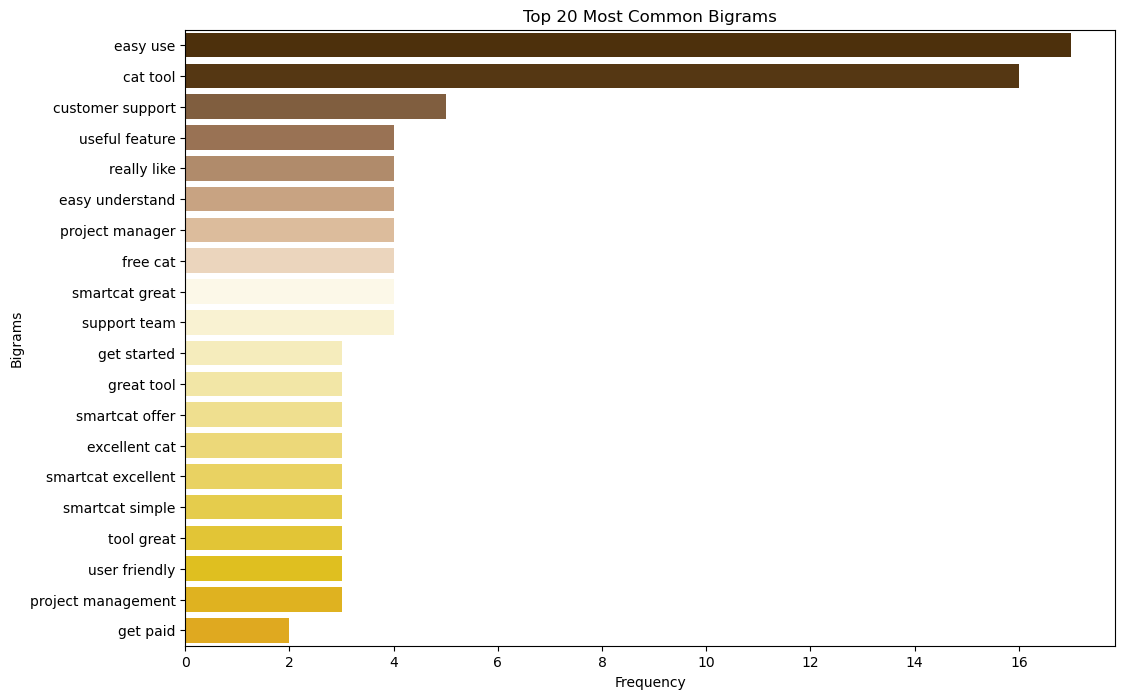

In [21]:
colors = ['#583101', '#603808', '#8B5E34', '#A47148', '#BC8A5F', '#D4A276', '#E7BC91', '#F3D5B5','#fffae5','#fff6cc','#fff2b2','#ffee99','#ffe97f','#ffe566','#ffe14c','#ffdd32','#ffd819','#ffd400', '#ffc300', '#ffb700']

plt.figure(figsize=(12, 8))
sns.barplot(x='frequency_pros', y='bigram_pros', data=bigram_df_pro_sm, palette=colors)
plt.title('Top 20 Most Common Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.show()

### 2. Calculate Sentiment Scores


In [22]:
sid = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))

def get_sentiment_scores(text):
    if pd.isna(text):
        return {'compound': 0, 'neg': 0, 'neu': 0, 'pos': 0}
    return sid.polarity_scores(text)
start_time = time.time()

# pros sentiments
smartcat['sentiment_scores_pros'] = smartcat['processed_Pros_NLTK'].apply(get_sentiment_scores)
lokalise['sentiment_scores_pros'] = lokalise['processed_Pros_NLTK'].apply(get_sentiment_scores)
crowdin['sentiment_scores_pros'] = crowdin['processed_Pros_NLTK'].apply(get_sentiment_scores)
transifex['sentiment_scores_pros'] = transifex['processed_Pros_NLTK'].apply(get_sentiment_scores)
plp['sentiment_scores_pros'] = plp['processed_Pros_NLTK'].apply(get_sentiment_scores)
murf_AI['sentiment_scores_pros'] = murf_AI['processed_Pros_NLTK'].apply(get_sentiment_scores)

# cons sentiments
smartcat['sentiment_scores_cons'] = smartcat['processed_Cons_NLTK'].apply(get_sentiment_scores)
lokalise['sentiment_scores_cons'] = lokalise['processed_Cons_NLTK'].apply(get_sentiment_scores)
crowdin['sentiment_scores_cons'] = crowdin['processed_Cons_NLTK'].apply(get_sentiment_scores)
transifex['sentiment_scores_cons'] = transifex['processed_Cons_NLTK'].apply(get_sentiment_scores)
plp['sentiment_scores_cons'] = plp['processed_Cons_NLTK'].apply(get_sentiment_scores)
murf_AI['sentiment_scores_cons'] = murf_AI['processed_Cons_NLTK'].apply(get_sentiment_scores)

final_df = pd.concat([smartcat, lokalise, crowdin, transifex, plp, murf_AI])

final_df['compound_pros'] = final_df['sentiment_scores_pros'].apply(lambda x: x['compound'])
final_df['neg_pros'] = final_df['sentiment_scores_pros'].apply(lambda x: x['neg'])
final_df['neu_pros'] = final_df['sentiment_scores_pros'].apply(lambda x: x['neu'])
final_df['pos_pros'] = final_df['sentiment_scores_pros'].apply(lambda x: x['pos'])

final_df['compound_cons'] = final_df['sentiment_scores_cons'].apply(lambda x: x['compound'])
final_df['neg_cons'] = final_df['sentiment_scores_cons'].apply(lambda x: x['neg'])
final_df['neu_cons'] = final_df['sentiment_scores_cons'].apply(lambda x: x['neu'])
final_df['pos_cons'] = final_df['sentiment_scores_cons'].apply(lambda x: x['pos'])

end_time = time.time()
duration = (end_time - start_time)/ 60
print(f"get_sentiment_scores function execution time: {duration:.2f} minutes")

get_sentiment_scores function execution time: 0.03 minutes


### 3. Visualize Sentiment Scores Distribution

In [23]:
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# fig.suptitle('Sentiment Scores Distribution')

# sns.histplot(df['compound'], bins=50, kde=True, ax=axes[0, 0], color='#6F4518')
# axes[0, 0].set_title('Compound Sentiment Score')

# sns.histplot(df['neg'], bins=50, kde=True, ax=axes[0, 1], color='#e01e37')
# axes[0, 1].set_title('Negative Sentiment Score')

# sns.histplot(df['neu'], bins=50, kde=True, ax=axes[1, 0], color='#bcb8b1')
# axes[1, 0].set_title('Neutral Sentiment Score')

# sns.histplot(df['pos'], bins=50, kde=True, ax=axes[1, 1], color='#386641')
# axes[1, 1].set_title('Positive Sentiment Score')

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()

### 4. Classify Reviews into Positive, Negative & Neutral

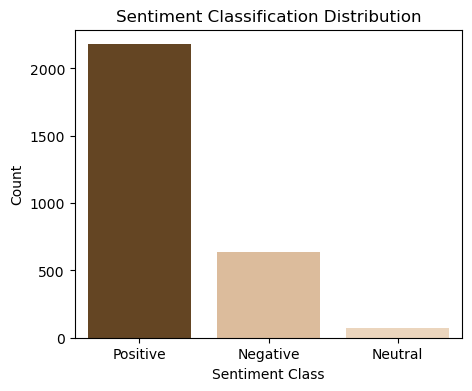

In [24]:
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

final_df['sentiment_class_pros'] = final_df['compound_pros'].apply(classify_sentiment)
final_df['sentiment_class_cons'] = final_df['compound_cons'].apply(classify_sentiment)


plt.figure(figsize=(5, 4))
colors = ['#6F4518', '#E7BC91', '#F3D5B5']

sns.countplot(x='sentiment_class_cons', data=final_df, palette=colors)
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.title('Sentiment Classification Distribution')
plt.show()

In [25]:
sentiment_counts = final_df['sentiment_class_pros'].value_counts()

positive_percentage = (sentiment_counts['Positive'] / len(df)) * 100
negative_percentage = (sentiment_counts['Negative'] / len(df)) * 100
neutral_percentage = (sentiment_counts['Neutral'] / len(df)) * 100

print(f"Percentage of Positive Reviews: {positive_percentage:.2f}%")
print(f"Percentage of Negative Reviews: {negative_percentage:.2f}%")
print(f"Percentage of Neutral Reviews: {neutral_percentage:.2f}%")

Percentage of Positive Reviews: 88.25%
Percentage of Negative Reviews: 1.35%
Percentage of Neutral Reviews: 10.40%


### 5. Generate Word Clouds for Positive and Negative Reviews

In [26]:
all_positive_words_list = final_df[final_df['sentiment_class_pros']=='Positive']['processed_Pros_NLTK'].str.split().tolist()
all_negative_words_list = final_df[final_df['sentiment_class_pros']=='Negative']['processed_Pros_NLTK'].str.split().tolist()
all_neutral_words_list = final_df[final_df['sentiment_class_pros']=='Neutral']['processed_Pros_NLTK'].str.split().tolist()

def extract_words(nested_list):
    words = []
    for item in nested_list:
        if isinstance(item, list):
            words.extend(extract_words(item))
        else:
            words.append(item)  
    return words

flat_list_pos = extract_words(all_positive_words_list)
flat_list_neg = extract_words(all_negative_words_list)
flat_list_neu = extract_words(all_neutral_words_list)

print(f"Number of positive unique words: {len(flat_list_pos)}")
print(f"Number of negative unique words: {len(flat_list_neg)}")
print(f"Number of neutral unique words: {len(flat_list_neu)}")

Number of positive unique words: 47490
Number of negative unique words: 653
Number of neutral unique words: 2478


In [27]:
# Create a Counter object
word_counts_pos = Counter(flat_list_pos)
word_counts_neg = Counter(flat_list_neg)
word_counts_neu = Counter(flat_list_neu)

positive_words_df = pd.DataFrame(pd.Series(word_counts_pos), columns=['Count']).sort_values(by='Count', ascending=False)
positive_words_df.index = positive_words_df.index.set_names(['Word'])
positive_words_df.reset_index(inplace=True)

negative_words_df = pd.DataFrame(pd.Series(word_counts_neg), columns=['Count']).sort_values(by='Count', ascending=False)
negative_words_df.index = negative_words_df.index.set_names(['Word'])
negative_words_df.reset_index(inplace=True)

neutral_words_df = pd.DataFrame(pd.Series(word_counts_neu), columns=['Count']).sort_values(by='Count', ascending=False)
neutral_words_df.index = neutral_words_df.index.set_names(['Word'])
neutral_words_df.reset_index(inplace=True)

positive_words_df.columns = ['Word', 'Count_Positive']
negative_words_df.columns = ['Word', 'Count_Negative']
neutral_words_df.columns = ['Word', 'Count_Neutral']

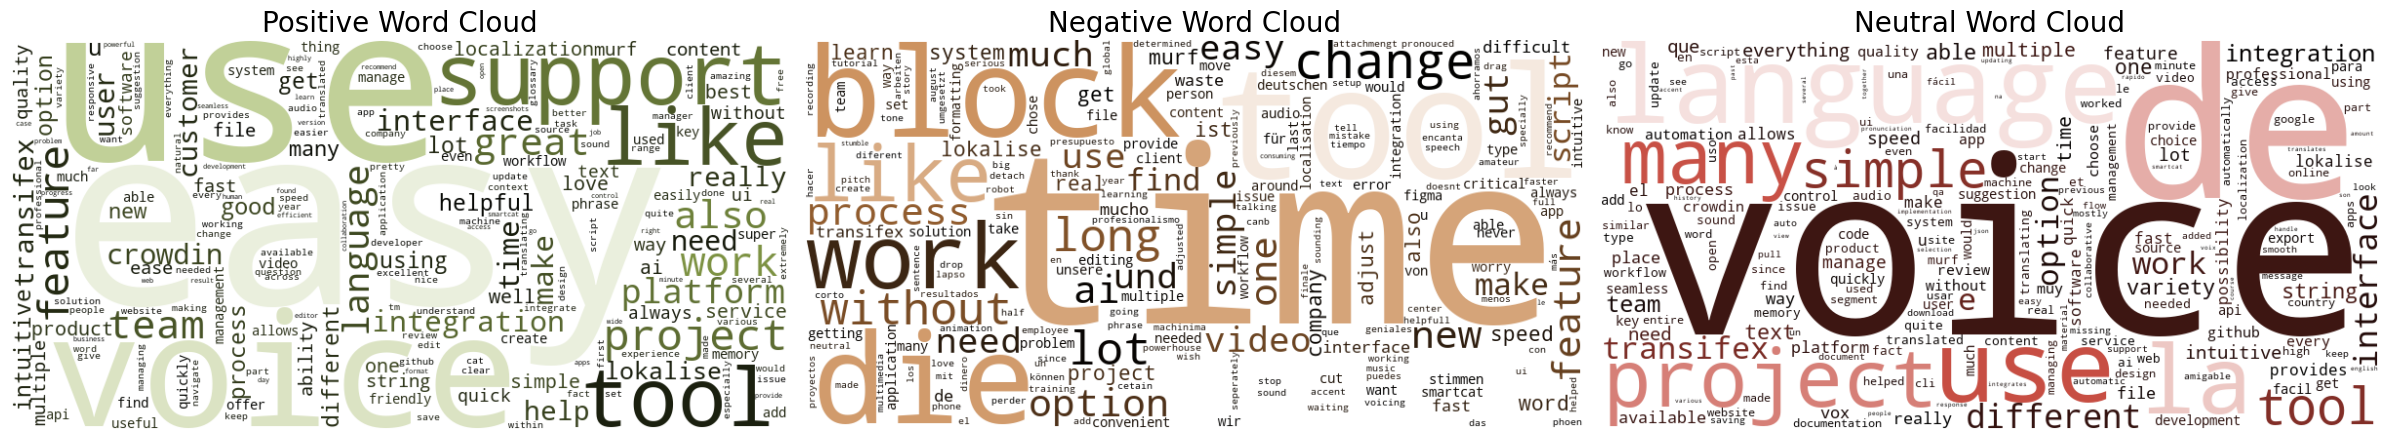

In [28]:
positive_frequencies = dict(zip(positive_words_df['Word'], positive_words_df['Count_Positive']))
negative_frequencies = dict(zip(negative_words_df['Word'], negative_words_df['Count_Negative']))
neutral_frequencies = dict(zip(neutral_words_df['Word'], neutral_words_df['Count_Neutral']))

# custom color functions
def positive_color_func(word, font_size, position, random_state, **kwargs):
    return "hsl(76, 37%, {:.2f}%)".format(font_size * random_state.random())

def negative_color_func(word, font_size, position, random_state, **kwargs):
    return "hsl(28, 52%, {:.2f}%)".format(font_size * random_state.random())

def neutral_color_func(word, font_size, position, random_state, **kwargs):
    return "hsl(5, 54%, {:.2f}%)".format(font_size * random_state.random())

# create word clouds with custom color functions
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=positive_color_func).generate_from_frequencies(positive_frequencies)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=negative_color_func).generate_from_frequencies(negative_frequencies)
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=neutral_color_func).generate_from_frequencies(neutral_frequencies)

fig, axes = plt.subplots(1, 3, figsize=(24, 10))

axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title('Positive Word Cloud', fontsize=20)
axes[0].axis('off')

axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].set_title('Negative Word Cloud', fontsize=20)
axes[1].axis('off')

axes[2].imshow(neutral_wordcloud, interpolation='bilinear')
axes[2].set_title('Neutral Word Cloud', fontsize=20)
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Topic Modeling with spaCy

In [37]:
text_column = 'processed_Pros_spaCy'
tp_df = final_df.dropna(subset=[text_column])

documents = tp_df[text_column].tolist()

vectorizer = CountVectorizer(max_features=1000, max_df=0.95, # ignore terms that appear in more than 95% of the documents
                             min_df=2,  stop_words='english')

# fit and transform the text data
X = vectorizer.fit_transform(documents)

feature_names = vectorizer.get_feature_names_out()

In [38]:
# function to display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

In [39]:
num_topics = 15

lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# number of top words to display for each topic
no_top_words = 15

print("Top 10 words in 'Cons':")
display_topics(lda, feature_names, no_top_words)

Top 10 words in 'Cons':
Topic 1:
great tool project feature platform use ability user management lot allow process crowdin like work

Topic 2:
interface user easy need friendly language use intuitive text simple lot app available platform free

Topic 3:
good crowdin option like time love useful work offer different fact function compare long tool

Topic 4:
use ai easy murf voice create video able work need look time audio ease option

Topic 5:
easy use work nice need tool great time help integrate integration product people project like

Topic 6:
support lokalise feature team project crowdin help allow new integration string app work provide customer

Topic 7:
language easy use like add multiple key different content ability way work project tool easily

Topic 8:
use team easy work platform manage project support ease like product crowdin transifex help quickly

Topic 9:
support easy use customer integration service ui team good helpful lokalise great quick work fast

Topic 10:
user fr

In [40]:
# get topic assignments for each document
topic_assignments = lda.transform(X)

# assign the most probable topic to each document
tp_df['topic_pros'] = topic_assignments.argmax(axis=1)

tp_df[['processed_Pros_spaCy', 'topic_pros']].head()

,processed_Pros_spaCy,topic_pros
0,quick start bane boon,4
1,1 quality 99 phrase correctly minimum post pro...,1
2,perfect need volume,12
3,splitting document segment easy deal project r...,14
4,intuitive ui ux design amazing customer suppor...,8


In [41]:
topic_mapping_pros = {
    0: 'User-Friendly Interface',
    1: 'User-Friendly Interface',
    2: 'Customer Support',
    3: 'AI/Voice',
    4: 'Product Integration',
    5: 'Customer Support',
    6: 'Language Support',
    7: 'Team Collaboration',
    8: 'Customer Support',
    9: 'Localization and Quality',
    10: 'Product Features',
    11: 'Customization',
    12: 'AI/Voice',
    13: 'Project Management',
    14: 'Project Management'
}

topic_mapping_cons = {
    0: 'Platform Limitations',
    1: 'Translation Issues',
    2: 'AI/Voice Issues',
    3: 'Integration Issues',
    4: 'Product Management Issues',
    5: 'Translation Issues',
    6: 'Platform Limitations',
    7: 'Usability Issues',
    8: 'Platform Limitations',
    9: 'Document Management Issues',
    10: 'AI/Voice Issues',
    11: 'Usability Issues',
    12: 'Localization Issues',
    13: 'Platform Issues',
    14: 'Usability Issues'
}

tp_df['Pros_Categories'] = tp_df['topic_pros'].map(topic_mapping_pros)


In [42]:
tp_df

,username,date,url,rating,product_name,Pros,Cons,processed_Pros_NLTK,processed_Pros_spaCy,processed_Cons_NLTK,processed_Cons_spaCy,sentiment_scores_pros,sentiment_scores_cons,compound_pros,neg_pros,neu_pros,pos_pros,compound_cons,neg_cons,neu_cons,pos_cons,sentiment_class_pros,sentiment_class_cons,topic_pros,Pros_Categories
0,No username found,2023-09-19,https://www.g2.com/products/smartcat/reviews/s...,2.0,Smartcat,Quick to get started but again that might be a...,The console is not user friendly and the platf...,quick get started might bane boon,quick start bane boon,console user friendly platform non transparent...,console user friendly platform non transparent...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.126, 'neu': 0.604, 'pos': 0.27, 'com...",0.0000,0.0,1.000,0.000,0.9412,0.126,0.604,0.270,Neutral,Positive,4,Product Integration
1,Alexis K.,2024-04-25,https://www.g2.com/products/smartcat/reviews/s...,5.0,Smartcat,1. Quality: 99% of phrases correctly translate...,Nothing. The quality of the service is excelle...,1 quality 99 phrase correctly translated minim...,1 quality 99 phrase correctly minimum post pro...,nothing quality service problem smartcat solvi...,quality service excellent problem smartcat sol...,"{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'comp...","{'neg': 0.0, 'neu': 0.583, 'pos': 0.417, 'comp...",0.5106,0.0,0.708,0.292,0.7819,0.000,0.583,0.417,Positive,Positive,1,User-Friendly Interface
2,Alina C.,2024-04-23,https://www.g2.com/products/smartcat/reviews/s...,5.0,Smartcat,It's perfect for my needs and the volume of tr...,Management changed the focus of this software ...,perfect need volume,perfect need volume,management changed focus software business pro...,management change focus software business comp...,"{'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp...","{'neg': 0.168, 'neu': 0.683, 'pos': 0.149, 'co...",0.5719,0.0,0.351,0.649,-0.0772,0.168,0.683,0.149,Positive,Negative,12,AI/Voice
3,Nebought K.,2024-05-17,https://www.g2.com/products/smartcat/reviews/s...,5.0,Smartcat,Splitting documents into segments makes it eas...,If there is little change you have to go throu...,splitting document segment make easy deal proj...,splitting document segment easy deal project r...,little change go segment suggest add replace f...,little change segment suggest add replace func...,"{'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...","{'neg': 0.109, 'neu': 0.64, 'pos': 0.252, 'com...",0.8591,0.0,0.727,0.273,0.6597,0.109,0.640,0.252,Positive,Positive,14,Project Management
4,Alexander M.,2023-10-15,https://www.g2.com/products/smartcat/reviews/s...,5.0,Smartcat,Intuitive UI/UX design. Amazing customer suppo...,The price could be a bit steep for startups.Wh...,intuitive design amazing customer support limi...,intuitive ui ux design amazing customer suppor...,price could bit steep problem smartcat solving...,price bit steep startup problem smartcat solve...,"{'neg': 0.0, 'neu': 0.515, 'pos': 0.485, 'comp...","{'neg': 0.134, 'neu': 0.746, 'pos': 0.119, 'co...",0.8555,0.0,0.515,0.485,-0.0772,0.134,0.746,0.119,Positive,Negative,8,Customer Support
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,No username found,2024-01-19,https://www.g2.com/products/murf-ai/reviews/mu...,5.0,Murf.ai,Brazilian Portuguese audio is clear. Export op...,Testing voices and returning to previous ones ...,brazilian portuguese audio clear export option...,brazilian portuguese audio clear export option...,testing voice returning previous one also cons...,testing voice return previous consume minute p...,"{'neg': 0.0, 'neu': 0.55, 'pos': 0.45, 'compou...","{'neg': 0.14, 'neu': 0.55, 'pos': 0.31, 'compo...",0.8402,0.0,0.550,0.450,0.7003,0.140,0.550,0.310,Positive,Positive,12,AI/Voice
996,No username found,2024-03-15,https://www.g2.com/products/murf-ai/reviews/mu...,3.5,Murf.ai,Simplicity of use and a user friendly UI,Less performing foreign voices and lack of too...,simplicity use us

In [35]:
dff = tp_df.copy()

In [43]:
dff['Pros_Categories'] = tp_df['Pros_Categories']

In [45]:
dff

,username,date,url,rating,product_name,Pros,Cons,processed_Pros_NLTK,processed_Pros_spaCy,processed_Cons_NLTK,processed_Cons_spaCy,sentiment_scores_pros,sentiment_scores_cons,compound_pros,neg_pros,neu_pros,pos_pros,compound_cons,neg_cons,neu_cons,pos_cons,sentiment_class_pros,sentiment_class_cons,topic_cons,Cons_Categories,Pros_Categories
0,No username found,2023-09-19,https://www.g2.com/products/smartcat/reviews/s...,2.0,Smartcat,Quick to get started but again that might be a...,The console is not user friendly and the platf...,quick get started might bane boon,quick start bane boon,console user friendly platform non transparent...,console user friendly platform non transparent...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.126, 'neu': 0.604, 'pos': 0.27, 'com...",0.0000,0.0,1.000,0.000,0.9412,0.126,0.604,0.270,Neutral,Positive,0,Platform Limitations,Product Integration
1,Alexis K.,2024-04-25,https://www.g2.com/products/smartcat/reviews/s...,5.0,Smartcat,1. Quality: 99% of phrases correctly translate...,Nothing. The quality of the service is excelle...,1 quality 99 phrase correctly translated minim...,1 quality 99 phrase correctly minimum post pro...,nothing quality service problem smartcat solvi...,quality service excellent problem smartcat sol...,"{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'comp...","{'neg': 0.0, 'neu': 0.583, 'pos': 0.417, 'comp...",0.5106,0.0,0.708,0.292,0.7819,0.000,0.583,0.417,Positive,Positive,14,Usability Issues,User-Friendly Interface
2,Alina C.,2024-04-23,https://www.g2.com/products/smartcat/reviews/s...,5.0,Smartcat,It's perfect for my needs and the volume of tr...,Management changed the focus of this software ...,perfect need volume,perfect need volume,management changed focus software business pro...,management change focus software business comp...,"{'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp...","{'neg': 0.168, 'neu': 0.683, 'pos': 0.149, 'co...",0.5719,0.0,0.351,0.649,-0.0772,0.168,0.683,0.149,Positive,Negative,0,Platform Limitations,AI/Voice
3,Nebought K.,2024-05-17,https://www.g2.com/products/smartcat/reviews/s...,5.0,Smartcat,Splitting documents into segments makes it eas...,If there is little change you have to go throu...,splitting document segment make easy deal proj...,splitting document segment easy deal project r...,little change go segment suggest add replace f...,little change segment suggest add replace func...,"{'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...","{'neg': 0.109, 'neu': 0.64, 'pos': 0.252, 'com...",0.8591,0.0,0.727,0.273,0.6597,0.109,0.640,0.252,Positive,Positive,6,Platform Limitations,Project Management
4,Alexander M.,2023-10-15,https://www.g2.com/products/smartcat/reviews/s...,5.0,Smartcat,Intuitive UI/UX design. Amazing customer suppo...,The price could be a bit steep for startups.Wh...,intuitive design amazing customer support limi...,intuitive ui ux design amazing customer suppor...,price could bit steep problem smartcat solving...,price bit steep startup problem smartcat solve...,"{'neg': 0.0, 'neu': 0.515, 'pos': 0.485, 'comp...","{'neg': 0.134, 'neu': 0.746, 'pos': 0.119, 'co...",0.8555,0.0,0.515,0.485,-0.0772,0.134,0.746,0.119,Positive,Negative,14,Usability Issues,Customer Support
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,No username found,2024-01-19,https://www.g2.com/products/murf-ai/reviews/mu...,5.0,Murf.ai,Brazilian Portuguese audio is clear. Export op...,Testing voices and returning to previous ones ...,brazilian portuguese audio clear export option...,brazilian portuguese audio clear export option...,testing voice returning previous one also cons...,testing voice return previous consume minute p...,"{'neg': 0.0, 'neu': 0.55, 'pos': 0.45, 'compou...","{'neg': 0.14, 'neu': 0.55, 'pos': 0.31, 'compo...",0.8402,0.0,0.550,0.450,0.7003,0.140,0.550,0.310,Positive,Positive,10,AI/Voice Issues,AI/Voice
996,No username found,2024-03-15,https://www.g2.com/products/murf-ai/r

In [84]:
dff.to_csv('final_data_G2_Reviews.csv', index=False)